In [1]:
from einops import reduce, rearrange, repeat
import days.gpt2 as gpt2
import days.bert as bert
import torch as t
from utils import tpeek
import matplotlib.pyplot as plt





In [2]:
model, _ = bert.my_bert_from_hf_weights()

No version set for command starship
Consider adding one of the following versions in your config file at /home/ubuntu/.tool-versions
rust 1.53.0
Already up to date.


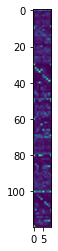

In [59]:
import subprocess
def hook_attentions(model):
    result = []

    def hook(module, _input, output):
        nonlocal result
        # tpeek(output)
        output = output[0]
        output = t.softmax(output, dim=-2)
        result.append(output)

    for block in model.transformer:
        block.attention.pattern.register_forward_hook(hook)
    return result

def show_attention_ascii_art(attentions,tokens):
    tmpname = "/home/ubuntu/mlab/days/ascii-temp-image.png"
    plt.imsave(tmpname,attentions.detach().numpy())
    asciiart = subprocess.check_output(f"ascii-image-converter {tmpname}",shell=True).decode("utf-8").strip()
    print("asciiart", asciiart)
    assert 1==2
    
    scale_factor=5
    scale_factor_vertical=int(1/2*scale_factor)
    assert len(tokens)==attentions.shape[0]
    fill_values =list(reversed("$@B%8&WM#*oahkbdpqwmZO0QLCJUYXzcvunxrjft/\|()1{}[]?-_+~<>i!lI;:,\"^`'. "))
    token_maxlen = max(len(t) for t in tokens)
    result = ""
    for line,token in zip(attentions,tokens):
        art_line="".join([fill_values[int(x*len(fill_values))]*scale_factor for x in line])
        result+=" "*(token_maxlen-len(token))+token+" "+ art_line+"\n"
        result+=(" "*token_maxlen+" "+art_line+"\n")*(scale_factor_vertical-1)
    for l in range(token_maxlen):
        result+=" "*token_maxlen+" "
        for t in tokens:
            if len(t)>l:
                result+=t[l]
            else:
                result+=" "
            result+=" "*(scale_factor-1)
        result+="\n"
    print(result)
    
def show_aggregate_attention(model, text):
    attention_buffer = hook_attentions(model)
    token_ids = model.tokenizer(text, return_tensors="pt")["input_ids"]
    tokens = [model.tokenizer.decode([x]) for x in token_ids[0]]
    model(token_ids)
    attention_vals = t.stack(attention_buffer, dim=0)
    # tpeek("attention buffer", attention_vals)
    attention_aggregate = reduce(attention_vals, "layer head from to -> from to", "mean")
    attention_aggregate_last = reduce(attention_vals[0], "head from to -> from to", "mean")
    # show_attention_ascii_art(attention_aggregate, tokens)

    # print(reduce(attention_vals, "l h f t -> t f","mean")[0].detach().numpy())
    plt.imshow(rearrange(attention_vals[0], "h f t -> (h f)  t").detach().numpy())
    
show_aggregate_attention(model, "The firetruck was painted bright red")

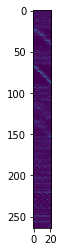

In [60]:
show_aggregate_attention(model, "The capital of Germany is Berlin. The capital of England is London. The capital of France is Paris")